In [1]:
import os
import numpy as np
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import neurokit2 as nk
import pandas as pd
from ecgdetectors import Detectors
import pyhrv.frequency_domain as fd
import pyhrv.time_domain as td
import pyhrv
import hrvanalysis
import pywt

In [2]:
import ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from scipy import signal
# import neurokit2 as nk
import random
# %matplotlib inline 
import pyhrv
import ipynb

In [4]:
# Dataset reading
class read_data_of_one_subject:
            """Read data from WESAD dataset"""
            def __init__(self, path, subject):
                self.keys = ['label', 'subject', 'signal']
                self.signal_keys = ['wrist', 'chest']
                self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
                self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
                #os.chdir(path)
                #os.chdir(subject)
                with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
                    data = pickle.load(file, encoding='latin1')
                self.data = data

            def get_labels(self):
                return self.data[self.keys[0]]

            def get_wrist_data(self):
                """"""
                #label = self.data[self.keys[0]]
                assert subject == self.data[self.keys[1]]
                signal = self.data[self.keys[2]]
                wrist_data = signal[self.signal_keys[0]]
                #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
                #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
                return wrist_data

            def get_chest_data(self):
                """"""
                signal = self.data[self.keys[2]]
                chest_data = signal[self.signal_keys[1]]
                return chest_data

In [4]:

# fs = 700 # sampling frequency
# y = []
# # data_set_path= "C:/Users/JackC/Documents/EPO4/WESAD/WESAD/" # Folder path
# data_set_path= "C:/Users/riche/Downloads/WESAD/WESAD/" # Folder path
# # data_set_path = "C:/Users/Adnane/Downloads/WESAD/WESAD/"

# subject = 'S6'
# obj_data = {}

# # Accessing class attributes and method through objects
# obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

# chest_data_dict = obj_data[subject].get_chest_data()
# chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}

# # Get labels
# labels = obj_data[subject].get_labels()
# baseline = np.asarray([idx for idx,val in enumerate(labels) if val == 1])

# ecg_base=chest_data_dict['ECG'][baseline,0] # Select the EDA data
# resp_base=chest_data_dict['Resp'][baseline,0] # Select the EDA data

In [5]:
# ecg2 = ecg_base[10000: 10000+ fs * 50]

In [5]:
# filtering
def filter_ecgsignal(ecg, fs):
    ecg_td = td.ecg(ecg, interactive= False, show = False, sampling_rate=fs)
    filtered_ecg = ecg_td['filtered']

    # t=np.arange(0,ecg.size*(1/fs),(1/fs))
    # t=t[:ecg.size]

    # plt.figure(figsize=(12,4))
    # plt.plot(t,ecg,label="raw ECG")
    # plt.plot(t,filtered_ecg, label="filtered ECG")
    # plt.xlabel('$Time (s)$') 
    # plt.ylabel('$ECG$') 
    # plt.legend(loc='upper left')

    return filtered_ecg

In [6]:
# detect R-peaks
def detect_rpeaks(fs, ecg):
    ecg_td = td.ecg(ecg, interactive= False, show = False, sampling_rate=fs)
    rpeaks = ecg_td['rpeaks']

    # plt.figure(figsize=(12,4))
    # plt.plot(filtered_ecg,label="ECG")
    # plt.plot(rpeaks,filtered_ecg[rpeaks], 'ro', label="R-peaks")
    # plt.xlabel('$Samples$') 
    # plt.ylabel('$ECG$') 
    # plt.legend(loc='upper left')
    return rpeaks

# **Feature extraction**

In [7]:
from hrv import HRV   # to import the module

# Feature extraction
def get_features(filtered_ecg, r_peaks_pan, fs, df, index):
    features = []
    features.append(index)
    # Time Domain Features
    hrv_class = HRV(fs)
    
    #Heart-rate feature extraction in BPM(HR)
    HR = hrv_class.HR(r_peaks_pan)
    features.append(np.mean(HR))
    features.append(np.min(HR))
    features.append(np.max(HR))
    features.append(np.std(HR))

    #Standard deviation of NN intervals(SDNN)
    features.append(hrv_class.SDNN(r_peaks_pan, normalise=True))

    #Standard deviation of the average of NN intervals(SDNN)
    features.append(hrv_class.SDANN(r_peaks_pan, normalise=True))

    #Root mean square of succesive differences(RMSSD)
    features.append(hrv_class.RMSSD(r_peaks_pan, normalise= True))

    # Standard deviation of succesive differences(SDSD)
    features.append(hrv_class.SDSD(r_peaks_pan))

    #The proportion of NN50 divided by total number of NNs(pNN50)
    features.append(hrv_class.pNN50(r_peaks_pan))

    #The proportion of NN20 divided by total number of NNs(pNN20)
    features.append(hrv_class.pNN20(r_peaks_pan))

    #Geometrical features('triangular_index', 'tinn')
    features.extend(hrvanalysis.extract_features.get_geometrical_features(r_peaks_pan).values())

    #Non-linear features ('sd1', 'sd2', 'ratio_sd2_sd1')
    features.extend(hrvanalysis.extract_features.get_poincare_plot_features(r_peaks_pan).values())

    # Frequency domain features
    rpeaks = r_peaks_pan / fs # R-peaks in sec
    ecg_fft = fd.frequency_domain(rpeaks = rpeaks, show = False) # get the frequency domain features of the HRV

    plt.close(ecg_fft["ar_plot"])
    plt.close(ecg_fft["lomb_plot"])
    plt.close(ecg_fft["fft_plot"])
    
    features.extend(ecg_fft['fft_abs'])
    features.append(ecg_fft['fft_total'])

    features.append(ecg_fft['fft_ratio'])
    features.extend(ecg_fft['fft_peak'])
    features.extend(ecg_fft['fft_norm'])

    cwt, freqs = pywt.cwt(filtered_ecg,np.arange(1,32),'mexh', sampling_period=2)

    # Computes CWT std value of each wavelet scale.
    cwt_absmean=np.abs(np.mean(cwt, axis=1))
    features.extend([max(cwt_absmean), min(cwt_absmean), np.mean(cwt_absmean), np.std(cwt_absmean)])

    # Computes CWT std value of each wavelet scale.
    cwt_std=np.std(cwt, axis=1)
    features.extend([max(cwt_std), min(cwt_std), np.mean(cwt_std), np.std(cwt_std)])

    # Computes CWT energy of each wavelet scale.
    cwt_energy = np.sqrt(np.sum(cwt ** 2, axis=1) / np.shape(cwt)[1])
    features.extend([max(cwt_energy), min(cwt_energy), np.mean(cwt_energy), np.std(cwt_energy)])

    # Computes CWT variance value of each wavelet scale.
    cwt_var=np.var(cwt, axis=1)
    features.extend([max(cwt_var), min(cwt_var), np.mean(cwt_var), np.std(cwt_var)])

    # Computes CWT entropy of the signal.
    energy_scale = np.sum(np.abs(cwt), axis=1)
    t_energy = np.sum(energy_scale)
    prob = energy_scale / t_energy
    w_entropy = -np.sum(prob * np.log(prob))
    features.append(w_entropy)

    #Respiration
    ecg_rate = nk.ecg_rate(r_peaks_pan, sampling_rate=fs, desired_length=len(filtered_ecg))
    edr = nk.ecg_rsp(ecg_rate, sampling_rate=fs, method="charlton2016")
    df_r, info = nk.rsp_process(edr, sampling_rate=fs)
    if len(info['RSP_Peaks'])>3:
        resp_feats = nk.rsp_analyze(df_r, sampling_rate=fs)
        
        for resp_feat in resp_feats.values[0]:
            features.append(resp_feat)
    else:
        features.extend(np.zeros(28))

    df.loc[index] = features
    return df

In [1]:
# get features from a signal and adds it to the dataframe
def get_ecgfeatures(ecg, fs, df, index):
    ecg = td.ecg(ecg, interactive= False, show = False, sampling_rate=fs)
    rpeaks = ecg['rpeaks']
    filtered_ecg = ecg['filtered']
    df_features = get_features(filtered_ecg, rpeaks, fs, df, index)
    return df_features

In [8]:
# columns_ecg =['index', 'ecg_HR_mean', 'ecg_HR_min', 'ecg_HR_max', 'ecg_HR_std', 'ecg_SDNN', 'ecg_SDANN', 'ecg_RMSSD', 
#                                            'ecg_SDSD','ecg_pNN50', 'ecg_pNN20', "ecg_triangular_index", "ecg_tinn", "ecg_sd1", "ecg_sd2",
#                                             "ecg_ratio_sd2_sd1", 'ecg_abs_power_VLF', 'ecg_abs_power_LF', 'ecg_abs_power_HF', 'ecg_tot_power',
#                                             'ecg_LF/HF', 'ecg_peak_vlf', 'ecg_peak_lf', 'ecg_peak_hf', 'ecg_norm_power_LF', 'ecg_norm_power_HF',
#                                             'max_cwt_absmean', 'min_cwt_absmean', 'mean_cwt_absmean','std_cwt_absmean', 
#                                             'max_cwt_std', 'min_cwt_std', 'mean_cwt_std','std_cwt_std',
#                                             'max_cwt_energy', 'min_cwt_energy', 'mean_cwt_energy','std_cwt_energy',
#                                             'max_cwt_var', 'min_cwt_var', 'mean_cwt_var','std_cwt_var',
#                                             'entropy']
# columns_resp = ['RSP_Rate_Mean','RRV_RMSSD', 'RRV_MeanBB', 'RRV_SDBB', 'RRV_SDSD', 'RRV_CVBB', 'RRV_CVSD', 'RRV_MedianBB',
#                 'RRV_MadBB', 'RRV_MCVBB', 'RRV_VLF', 'RRV_LF', 'RRV_HF', 'RRV_LFHF', 'RRV_LFn', 'RRV_HFn', 'RRV_SD1',
#                 'RRV_SD2', 'RRV_SD2SD1', 'RRV_ApEn', 'RRV_SampEn', 'RSP_Amplitude_Mean', 'RSP_RVT', 'RSP_Symmetry_PeakTrough',
#                 'RSP_Symmetry_RiseDecay', 'RSP_Phase_Duration_Inspiration', 'RSP_Phase_Duration_Expiration', 'RSP_Phase_Duration_Ratio']
# columns = [*columns_ecg, *columns_resp]
# ecgfeatures = pd.DataFrame(None, columns= columns)

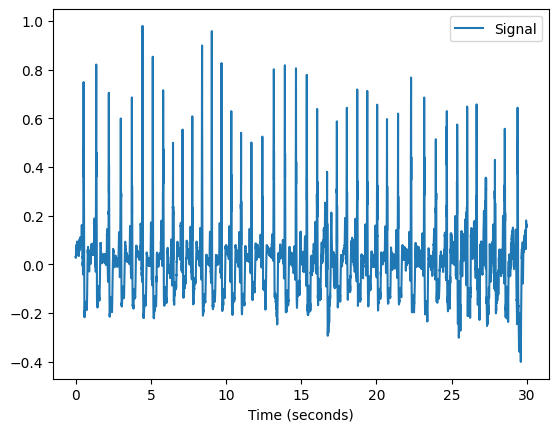

In [19]:
# nk.signal_plot(ecg, sampling_rate=700)

In [41]:
# # Dataset reading
# class read_data_of_one_subject:
#             """Read data from WESAD dataset"""
#             def __init__(self, path, subject):
#                 self.keys = ['label', 'subject', 'signal']
#                 self.signal_keys = ['wrist', 'chest']
#                 self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
#                 self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
#                 #os.chdir(path)
#                 #os.chdir(subject)
#                 with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
#                     data = pickle.load(file, encoding='latin1')
#                 self.data = data

#             def get_labels(self):
#                 return self.data[self.keys[0]]

#             def get_wrist_data(self):
#                 """"""
#                 #label = self.data[self.keys[0]]
#                 #assert subject == self.data[self.keys[1]]
#                 signal = self.data[self.keys[2]]
#                 wrist_data = signal[self.signal_keys[0]]
#                 #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
#                 #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
#                 return wrist_data

#             def get_chest_data(self):
#                 """"""
#                 signal = self.data[self.keys[2]]
#                 chest_data = signal[self.signal_keys[1]]
#                 return chest_data

In [42]:
# fs = 700 # sampling frequency
# fs_bvp = 64
# duration = 30
# y = []
# # data_set_path= "C:/Users/JackC/Documents/EPO4/WESAD/WESAD/" # Folder path
# data_set_path= "C:/Users/riche/Downloads/WESAD/WESAD/" # Folder path
# # data_set_path = "C:/Users/Adnane/Downloads/WESAD/WESAD/"
# subject = 'S8'
# # Object instantiation
# obj_data = {}

# # Accessing class attributes and method through objects
# obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

# chest_data_dict = obj_data[subject].get_chest_data()
# chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}

# # Get labels
# labels = obj_data[subject].get_labels()
# label = 1
# baseline = np.asarray([idx for idx,val in enumerate(labels) if val == label])
# ecg_base=chest_data_dict['ECG'][baseline,0] # Select the ECG data
# ecg = ecg_base[10000:30*fs+10000]

In [50]:
# fs = 700
# ecg2 = td.ecg(ecg, interactive= False, show = False, sampling_rate=700)
# rpeaks = ecg2['rpeaks']
# filtered_ecg = ecg2['filtered']
# features = []

# ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=len(filtered_ecg))
# edr = nk.ecg_rsp(ecg_rate, sampling_rate=fs, method="charlton2016")
# df_r, info = nk.rsp_process(edr, sampling_rate=fs)
# print(len(info['RSP_Peaks']))
# # resp_feats = nk.rsp_analyze(df_r, sampling_rate=fs)

# # for resp_feat in resp_feats.values[0]:
# #     features.append(resp_feat)
# # features
# # get_features(filtered_ecg, rpeaks, 700, ecgfeatures, 'S1')

3


In [48]:
# fs = 700
# ecg2 = td.ecg(ecg, interactive= False, show = False, sampling_rate=700)
# rpeaks = ecg2['rpeaks']
# filtered_ecg = ecg2['filtered']
# features = []

# ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=len(filtered_ecg))
# edr = nk.ecg_rsp(ecg_rate, sampling_rate=fs, method="charlton2016")
# df_r, info = nk.rsp_process(edr, sampling_rate=fs)
# peaks = info['RSP_Peaks']
# print(info)
# # resp_feats = nk.rsp_analyze(df_r, sampling_rate=fs)

# # for resp_feat in resp_feats.values[0]:
# #     features.append(resp_feat)
# # features
# # get_features(filtered_ecg, rpeaks, 700, ecgfeatures, 'S1')

{'RSP_Peaks': array([ 4860, 14415, 18563], dtype=int64), 'RSP_Troughs': array([ 1523,  9195, 15683], dtype=int64), 'sampling_rate': 700}
